In [1]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("fill-mask", model="faisalq/SaudiBERT")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/630 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/575M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/970 [00:00<?, ?B/s]

Device set to use cpu


In [2]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("faisalq/SaudiBERT")
model = AutoModelForMaskedLM.from_pretrained("faisalq/SaudiBERT")

In [6]:
!pip install transformers torch scikit-learn pandas numpy matplotlib seaborn tqdm emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 6.3 MB/s eta 0:00:00


In [7]:
import re
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# Transformers / Torch
from transformers import AutoTokenizer, AutoModel
import torch

# ML
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

# Plot
import matplotlib.pyplot as plt
import seaborn as sns


In [17]:
#  إعداد وقراءة البيانات

DATA_PATH = "reviews.csv"
MODEL_NAME = "faisalq/SaudiBERT"  # موديل SaudiBERT على Hugging Face

def load_data(path=DATA_PATH):
    df = pd.read_csv(path)
    # نتوقع أعمدة: review_text, rating
    if "Review Text" not in df.columns:
        raise ValueError("CSV must contain column 'Review Text'")
    if "Rating" not in df.columns:
        print("Warning: 'Rating' column not found — سيتم محاولة الاستمرار بدون تسميات.")
    return df

In [9]:
# 2) تنظيف / تطبيع النص العربي


# حذف التشكيل
def remove_diacritics(text):
    arabic_diacritics = re.compile("""
         ّ    | # Tashdid
         َ    | # Fatha
         ً    | # Tanwin Fath
         ُ    | # Damma
         ٌ    | # Tanwin Damm
         ِ    | # Kasra
         ٍ    | # Tanwin Kasr
         ْ    | # Sukun
         ـ     # Tatwil/Kashida
     """, re.VERBOSE)
    return re.sub(arabic_diacritics, "", text)

# إزالة الروابط و الإيموجي و الوسوم و الرموز غير الضرورية
def clean_misc(text):
    text = str(text)
    # إزالة روابط
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    # إزالة mentions و hashtags
    text = re.sub(r'@[^\s]+|#[^\s]+', ' ', text)
    # إزالة رموز غير عربية أو أرقام
    # إزالة علامات التشكيل الطويلة أو زيادة الحروف (التمديد)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)  # تقليص التمديدات AAA -> AA
    # إزالة أي حرف لاتيني زائد (اختياري: يمكن إبقاؤها)
    # text = re.sub(r'[A-Za-z]', ' ', text)
    # إزالة رموز غير الحروف والأرقام وبعض علامات الترقيم الضرورية
    text = re.sub(r'[^\w\s\u0600-\u06FF\u0750-\u077F]', ' ', text)
    # توحيد المسافات
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# توحيد بعض الحروف (ألف وما شابه)
def normalize_arabic(text):
    text = text.replace('إ', 'ا').replace('أ', 'ا').replace('آ', 'ا')
    text = text.replace('ة', 'ه')  # خيار: تحويل التاء المربوطة إلى ه أو العكس
    text = text.replace('ى', 'ي')
    text = text.replace('ؤ', 'و').replace('ئ', 'ي')
    return text

def preprocess_text(text):
    text = str(text)
    text = text.strip()
    text = text.replace('\n', ' ').replace('\r', ' ')
    text = remove_diacritics(text)
    text = clean_misc(text)
    text = normalize_arabic(text)
    return text


In [10]:
import string

# تنظيف النصوص الإنجليزية
def clean_english(text):
    text = str(text)
    # lowercase
    text = text.lower()
    # remove urls
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    # remove mentions and hashtags
    text = re.sub(r'@[^\s]+|#[^\s]+', ' ', text)
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # remove numbers (اختياري)
    text = re.sub(r'\d+', ' ', text)
    # collapse multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# نسخة مدمجة تختار اللغة (مبسطة بالاعتماد على الحروف)
def preprocess_text_mixed(text):
    text = str(text).strip()
    # إذا النص يحتوي أغلبه عربي
    if re.search(r'[\u0600-\u06FF]', text):
        return preprocess_text(text)  # تستخدم دوال العربية
    else:
        return clean_english(text)


In [11]:
# تحميل SaudiBERT لاستخراج embeddings


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

print("Loading SaudiBERT tokenizer and model:", MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.to(device)
model.eval()

# دالة للحصول على embedding (mean pooling) لكل جملة
def get_embedding(text, max_length=128):
    # tokenizer سيعالج التقطيع والـ padding
    with torch.no_grad():
        inputs = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=max_length,
            padding="max_length"
        ).to(device)
        outputs = model(**inputs)
        # outputs.last_hidden_state shape: (1, seq_len, hidden_size)
        last_hidden = outputs.last_hidden_state
        attention_mask = inputs["attention_mask"].unsqueeze(-1)  # (1, seq_len, 1)
        masked = last_hidden * attention_mask
        summed = masked.sum(dim=1)
        counts = attention_mask.sum(dim=1).clamp(min=1e-9)
        mean_pooled = summed / counts
        return mean_pooled.cpu().numpy().reshape(-1)  # 1D vector

Using device: cpu
Loading SaudiBERT tokenizer and model: faisalq/SaudiBERT


Some weights of BertModel were not initialized from the model checkpoint at faisalq/SaudiBERT and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
#  تجهيز البيانات (labels)


def rating_to_label(r):
    # خريطة بسيطة: 4-5 -> positive, 3 -> neutral, 1-2 -> negative
    try:
        r = float(r)
    except:
        return None
    if r >= 4.0:
        return "positive"
    elif r == 3.0:
        return "neutral"
    else:
        return "negative"

def prepare_dataset(df, text_col="Review Text", rating_col="Rating", sample_limit=None):
    df = df.copy()
    # تنظيف النص
    tqdm.pandas(desc="Preprocessing texts")
    df["clean_text"] = df[text_col].progress_apply(preprocess_text_mixed)
    # إعداد تسميات اعتمادًا على التقييم لو كانت موجودة
    if rating_col in df.columns:
        df["label"] = df[rating_col].apply(rating_to_label)
        df = df.dropna(subset=["label"])  # نحذف الصفوف بدون rating صالح
    else:
        df["label"] = None
    if sample_limit:
        df = df.sample(n=sample_limit, random_state=42)
    return df

In [20]:
#  استخراج الـ embeddings لكل تعليق

def compute_embeddings(df, text_col="clean_text"):
    embeddings = []
    for txt in tqdm(df[text_col].tolist(), desc="Computing embeddings"):
        emb = get_embedding(txt)
        embeddings.append(emb)
    X = np.vstack(embeddings)
    return X

In [21]:
#  تدريب مصفف (Logistic Regression) وتقييمه


def train_and_evaluate(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    print("Classification report:\n", classification_report(y_test, preds))
    cm = confusion_matrix(y_test, preds, labels=["positive", "neutral", "negative"])
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["positive","neutral","negative"],
                yticklabels=["positive","neutral","negative"])
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
    plt.show()
    return clf


In [22]:
# استخراج كلمات مميّزة لكل فئة (بسيط باستخدام TF-IDF)


def top_tfidf_words_by_label(df, n=15):
    tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
    docs = df["clean_text"].fillna("").tolist()
    X = tfidf.fit_transform(docs)
    features = np.array(tfidf.get_feature_names_out())
    labels = df["label"].unique()
    top_words = {}
    for lab in labels:
        idxs = df[df["label"] == lab].index.tolist()
        if len(idxs) == 0:
            top_words[lab] = []
            continue
        mean_tfidf = X[idxs].mean(axis=0).A1
        top_n_idx = mean_tfidf.argsort()[-n:][::-1]
        top_words[lab] = features[top_n_idx].tolist()
    return top_words


Loaded 2498 rows


Preprocessing texts:   0%|          | 0/2498 [00:00<?, ?it/s]

After preprocessing: (2498, 9)
Saved processed data to processed_reviews.csv


Computing embeddings:   0%|          | 0/2498 [00:00<?, ?it/s]

Classification report:
               precision    recall  f1-score   support

    negative       0.68      0.50      0.57        50
     neutral       0.38      0.26      0.31        46
    positive       0.90      0.96      0.92       404

    accuracy                           0.85       500
   macro avg       0.65      0.57      0.60       500
weighted avg       0.83      0.85      0.83       500



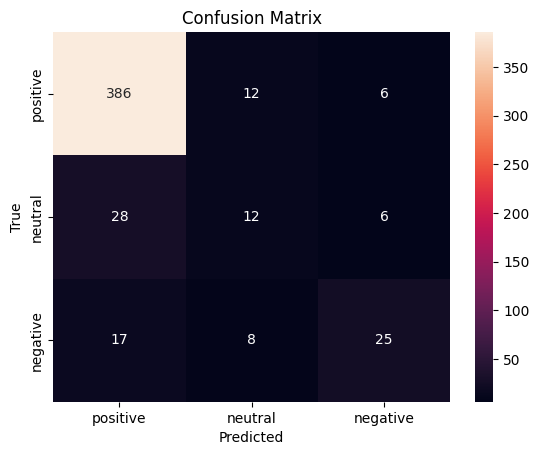


Top words for positive:
لذيذ, وافل, الوافل, جدا, المكان, مره, نكهه, بروليه, الله, جميل, ممتاز, صغير, الذ, لذيذه, القهوه, عندهم, الكريم, قهوه, كريم

Top words for negative:
جدا, الوافل, بارد, ولا, وافل, القهوه, مره, عادي جدا, طعم, الطعم, اقل من, اقل, فيه, للاسف

Top words for neutral:
الوافل, جدا, وافل, مره, القهوه, المكان, صغير, overrated, قهوه, فيه, قهوه اليوم, بروليه, جيد, السعر, لذيذ, كانت
Saved classifier and tokenizer.


In [33]:
# --------------------------- Main flow ---------------------------
def main():
    #  تحميل البيانات ومعالجتها
    df = load_data(DATA_PATH)
    print("Loaded", len(df), "rows")
    df = prepare_dataset(df)
    print("After preprocessing:", df.shape)

    # حفظ البيانات المعالجة
    processed_data_path = "processed_reviews.csv"
    df.to_csv(processed_data_path, index=False)
    print(f"Saved processed data to {processed_data_path}")

    #  التحقق من وجود التصنيفات (labels)
    if "label" not in df.columns or df["label"].isnull().all():
        print("No labels found. Pipeline will stop after cleaning and TF-IDF summary.")
        print(df[["clean_text"]].head(10).to_string(index=False))
        return

    #  حساب embeddings
    X = compute_embeddings(df, text_col="clean_text")
    y = df["label"].values

    #  تدريب وتقييم الموديل
    clf = train_and_evaluate(X, y)

    #  استخراج الكلمات المميزة لكل تصنيف
    top_words = top_tfidf_words_by_label(df, n=25)

    # ----------------- قائمة كلمات توقف -----------------
    arabic_stopwords = set([
        "من", "في", "على", "ما", "لا", "مع", "كان", "كل", "لكن", "اليوم", "بس",
        "ابدا", "عادي", "هذا", "اللي", "ل", "عن", "و", "وهو", "وهي", "قد", "جربت"
    ])
    english_stopwords = set([
        "the", "and", "is", "was", "a", "of", "for", "in", "to", "it", "i", "my"
    ])

    # ----------------- فلترة ذكية للكلمات -----------------
    def filter_top_words_smart(top_words_dict, min_length=3):
        filtered = {}
        for label, words in top_words_dict.items():
            new_words = [
                w for w in words
                if w not in arabic_stopwords
                and w not in english_stopwords
                and w != "nan"
                and len(w) >= min_length
            ]
            filtered[label] = new_words
        return filtered

    top_words_filtered = filter_top_words_smart(top_words)

    # عرض الكلمات بعد التنقية
    for lab, words in top_words_filtered.items():
        print(f"\nTop words for {lab}:")
        print(", ".join(words))

    #  حفظ المصنف وميزات التوكنيزر
    import joblib
    joblib.dump(clf, "saudibert_logreg_clf.joblib")
    tokenizer.save_pretrained("saudibert_tokenizer_saved")
    print("Saved classifier and tokenizer.")


if __name__ == "__main__":
    main()


Arabic font found: /Amiri-Bold.ttf
✅ Saved: wordclouds/arabic_positive.png
✅ Saved: wordclouds/arabic_negative.png
✅ Saved: wordclouds/english_positive.png
✅ Saved: wordclouds/english_negative.png


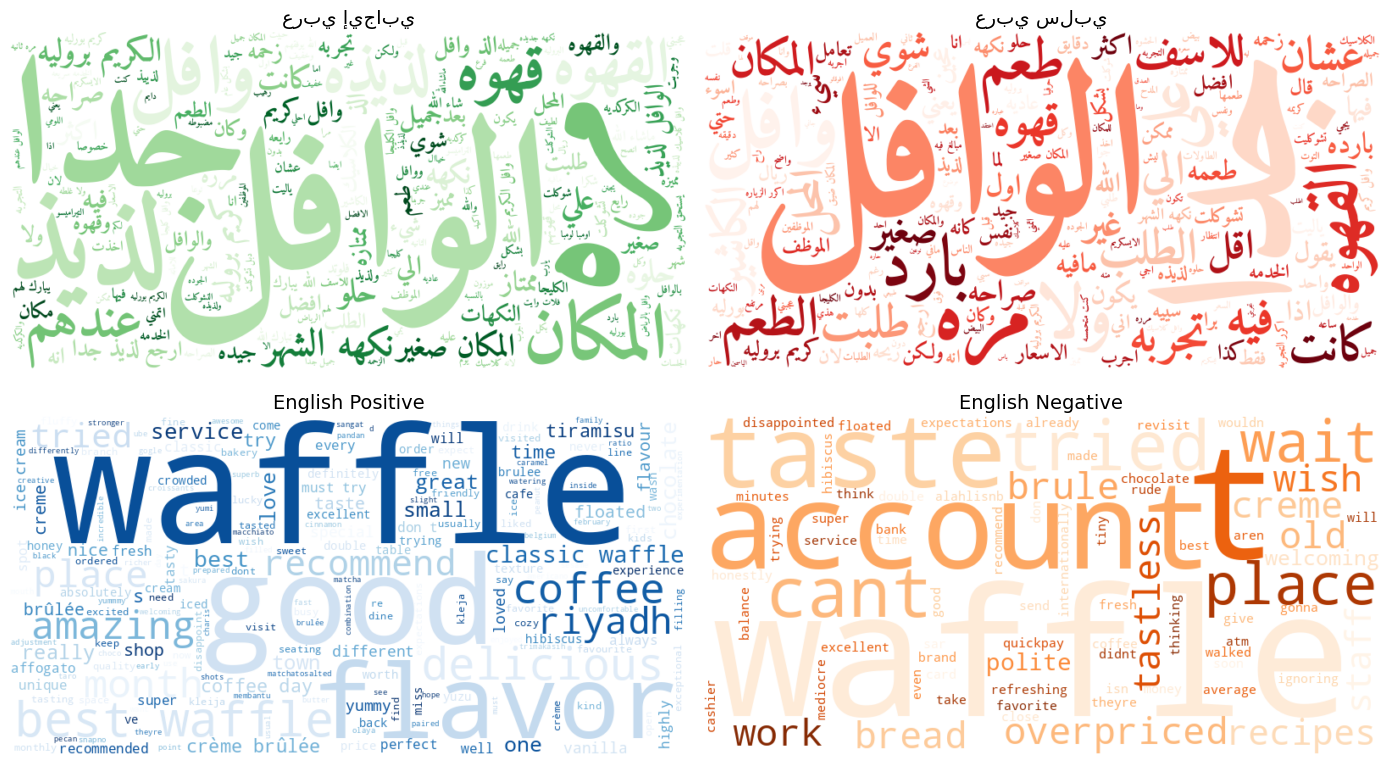

In [42]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import os

# --------  تحديد الخط العربي مباشرة --------
arabic_font = "/Amiri-Bold.ttf"  # مسار الخط بعد تحميله

if os.path.exists(arabic_font):
    print("Arabic font found:", arabic_font)
else:
    from matplotlib import rcParams
    rcParams['font.family'] = 'DejaVu Sans'
    print("Arabic font not found. Using default font.")
    arabic_font = None  # لتفادي تمرير مسار خاطئ لـ WordCloud

# --------  فصل النصوص حسب اللغة --------
def is_arabic(text):
    return bool(re.search(r'[\u0600-\u06FF]', str(text)))

def split_by_language(df):
    df_ar = df[df["clean_text"].apply(is_arabic)]
    df_en = df[~df["clean_text"].apply(is_arabic)]
    return df_ar, df_en

# --------  كلمات توقف للفلترة --------
arabic_stopwords = set([
    "من", "في", "على", "ما", "لا", "مع", "كان", "كل", "لكن", "اليوم", "بس",
    "ابدا", "عادي", "هذا", "اللي", "ل", "عن", "و", "وهو", "وهي", "قد", "جربت"
])
english_stopwords = set([
    "the", "and", "is", "was", "a", "of", "for", "in", "to", "it", "i", "my"
])

# --------  فلترة النصوص قبل WordCloud --------
def filter_texts_for_wordcloud(texts, min_length=3):
    filtered_texts = []
    for text in texts:
        if not isinstance(text, str):
            continue
        words = text.split()
        words = [w for w in words if w not in arabic_stopwords and w not in english_stopwords and len(w) >= min_length]
        if words:
            filtered_texts.append(" ".join(words))
    return filtered_texts

# --------  إنشاء WordCloud --------
def make_wordcloud(texts, font_path=None, colormap="Blues"):
    text_joined = " ".join([str(t) for t in texts if isinstance(t, str)])
    wc = WordCloud(width=800, height=400,
                   background_color="white",
                   font_path=font_path,
                   colormap=colormap).generate(text_joined)
    return wc

# --------  التصور + الحفظ --------
def plot_wordclouds(df, out_dir="wordclouds"):
    os.makedirs(out_dir, exist_ok=True)
    df_ar, df_en = split_by_language(df)

    categories = [
        (df_ar[df_ar["label"]=="positive"]["clean_text"], "عربي إيجابي", "Greens", arabic_font, "arabic_positive.png"),
        (df_ar[df_ar["label"]=="negative"]["clean_text"], "عربي سلبي", "Reds", arabic_font, "arabic_negative.png"),
        (df_en[df_en["label"]=="positive"]["clean_text"], "English Positive", "Blues", None, "english_positive.png"),
        (df_en[df_en["label"]=="negative"]["clean_text"], "English Negative", "Oranges", None, "english_negative.png")
    ]

    fig, axes = plt.subplots(2,2, figsize=(14,8))

    for ax, (texts, title, cmap, font, fname) in zip(axes.flat, categories):
        texts_filtered = filter_texts_for_wordcloud(texts)
        wc = make_wordcloud(texts_filtered, font_path=font, colormap=cmap)
        ax.imshow(wc, interpolation="bilinear")
        ax.axis("off")
        ax.set_title(title, fontsize=14)
        wc.to_file(f"{out_dir}/{fname}")
        print(f"✅ Saved: {out_dir}/{fname}")

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    import pandas as pd

    # تحميل البيانات المصنفة بعد التدريب
    df = pd.read_csv("processed_reviews.csv")  # يجب أن يحتوي على الأعمدة clean_text و label
    plot_wordclouds(df)
